# Replicate Fig 1

In this notebook we will be replicating figure 1 of the paper *Whole-animal connectome and cell-type complement of the three-segmented Platynereis dumerilii larva*, which is a network plot of the neurons in the larva's connectome

In [29]:
import os
import logging
import pandas as pd
import numpy as np
import networkx as nx
from itertools import chain, combinations
from upsetplot import plot
from matplotlib import pyplot as plt
from networkx import from_numpy_array, number_of_nodes, number_of_edges, density
from graspologic.embed import AdjacencySpectralEmbed
from graspologic.layouts import layout_tsne, layout_umap
from graspologic.plot.plot import networkplot
from graspologic.utils import is_fully_connected, largest_connected_component, is_symmetric, symmetrize
from pkg.platy import load_connectome_adj, _get_folder

In [30]:
folder = _get_folder()

We import the adjacency matrix for the connection of connectome neurons and save its edgelist (note: we are working with a directed graph)

In [34]:
adj = load_connectome_adj()
g = nx.from_pandas_adjacency(adj, create_using=nx.DiGraph)
nx.write_edgelist(g, folder / "weighted_connectome_edgelist.csv")

To be able to make a network plot of the connectome neurons, we need to extract the largest connected component of the neurons, as there are a few neurons that have a degree of 0 (no incident edges), which we cannot plot

In [35]:
#numpy representation of original graph
adj_numpy_orig = adj.to_numpy()

#numpy largest connected component
adj_numpy_lcc, new_inds = largest_connected_component(adj_numpy_orig, return_inds=True)

In [36]:
#symmetrized version of numpy_lcc
adj_numpy_sym_lcc = symmetrize(adj_numpy_lcc)

#networkx representation of symmetrized lcc graph
adj_nx_sym_lcc = nx.from_numpy_array(adj_numpy_sym_lcc, create_using=nx.DiGraph)
print(adj_nx_sym_lcc)

DiGraph with 2723 nodes and 21691 edges


In [37]:
#use layout_tsne to get 2d representation of graph
X, node_pos = layout_tsne(adj_nx_sym_lcc, perplexity=100, n_iter=10000)
x_pos = []
y_pos = []
node_comms = []
for pos in node_pos:

    #save the assigned community of the node
    node_comms.append(pos[4])
    x_pos.append(pos[1])
    y_pos.append(pos[2])

node_comms = np.array(node_comms)
x_pos = np.array(x_pos)
y_pos = np.array(y_pos)
degrees = np.sum(adj_numpy_sym_lcc, axis=0)

/Users/kareefullah/Library/Caches/pypoetry/virtualenvs/platy-data-EVeqgmAk-py3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/kareefullah/Library/Caches/pypoetry/virtualenvs/platy-data-EVeqgmAk-py3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


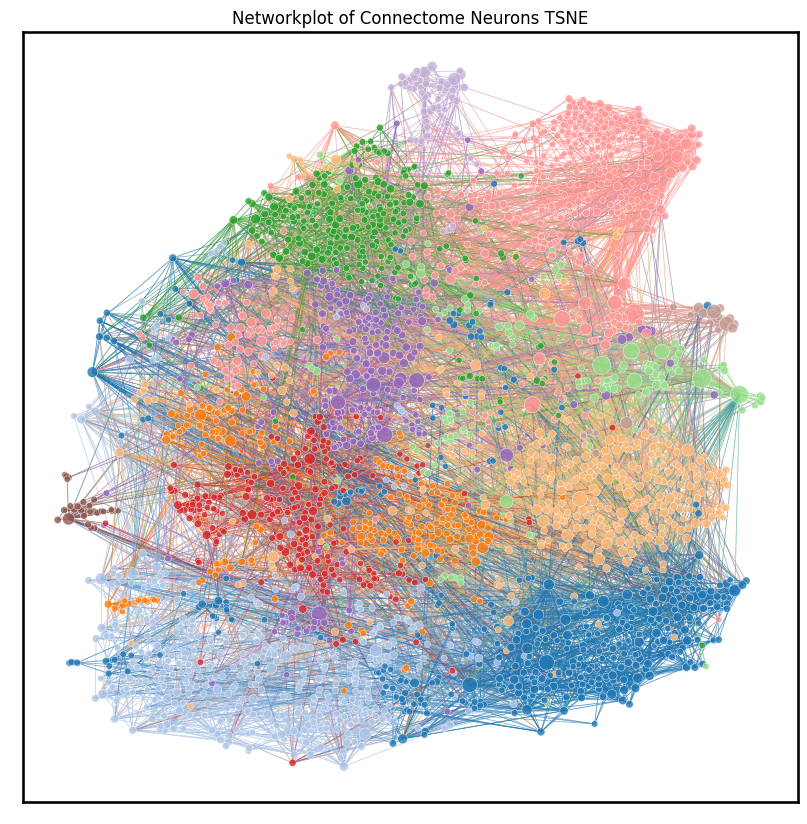

In [38]:
plot = networkplot(
    adjacency=adj_numpy_sym_lcc,
    x=x_pos,
    y=y_pos,
    node_hue=node_comms,
    palette="tab20",
    node_size=degrees,
    node_sizes=(20, 200),
    edge_hue="source",
    edge_alpha=0.5,
    edge_linewidth=0.5,
)
plt.title("Networkplot of Connectome Neurons TSNE")
plt.savefig(folder / "tsne_connectome.png")
plt.show()

In [39]:
#use layout_tsne to get 2d representation of graph
X, node_pos = layout_umap(adj_nx_sym_lcc)
x_pos = []
y_pos = []
node_comms = []
for pos in node_pos:
    node_comms.append(pos[4])
    x_pos.append(pos[1])
    y_pos.append(pos[2])

node_comms = np.array(node_comms)
x_pos = np.array(x_pos)
y_pos = np.array(y_pos)
degrees = np.sum(adj_numpy_sym_lcc, axis=0)

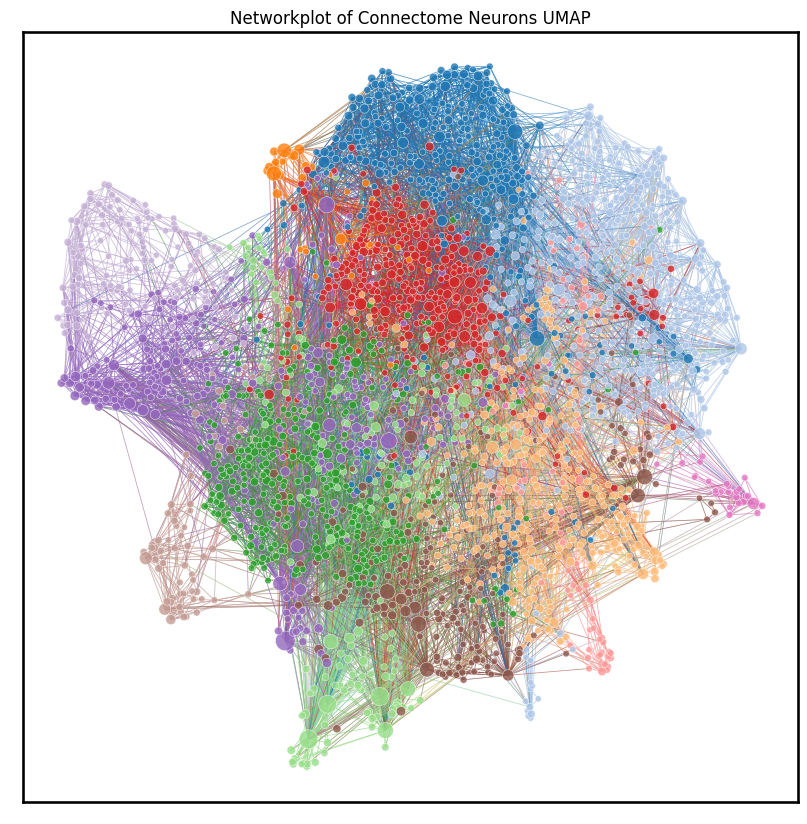

In [40]:
plot = networkplot(
    adjacency=adj_numpy_sym_lcc,
    x=x_pos,
    y=y_pos,
    node_hue=node_comms,
    palette="tab20",
    node_size=degrees,
    node_sizes=(20, 200),
    edge_hue="source",
    edge_alpha=0.5,
    edge_linewidth=0.5,
)
plt.title("Networkplot of Connectome Neurons UMAP")
plt.savefig(folder / "umap_connectome.png")
plt.show()

We are now interested in displaying the statistics from the graph we generated to that of the statistics given in table 1 of the paper, and we wish to make sure that our numbers are approximately the same

In [41]:
#given the adjacency matrix and a partition of the nodes return the modularity score
def modularity_from_adjacency(sym_adj, partition, resolution=1):
    if isinstance(partition, dict):
        partition_labels = np.vectorize(partition.__getitem__)(
            np.arange(sym_adj.shape[0])
        )
    else:
        partition_labels = partition
    partition_labels = np.array(partition_labels)
    in_comm_mask = partition_labels[:, None] == partition_labels[None, :]
    degrees = np.squeeze(np.asarray(sym_adj.sum(axis=0)))
    degree_prod_mat = np.outer(degrees, degrees) / sym_adj.sum()
    mod_mat = sym_adj - resolution * degree_prod_mat
    return mod_mat[in_comm_mask].sum() / sym_adj.sum()

In [42]:
#get original networkx graph (not lcc)
adj_nx_orig = nx.from_numpy_array(adj_numpy_orig, create_using=nx.DiGraph)

#stats on original graph
n_nodes_orig = adj_nx_orig.number_of_nodes()
n_edges_orig = adj_nx_orig.number_of_edges()
dens_orig = density(adj_nx_orig)

#cannot calc modularity because there are isolate nodes
mod_score_orig = "N/A"

avg_degree_orig = np.average(np.count_nonzero(adj_numpy_orig, axis=0))
avg_degree_orig

4.234237536656892

In [43]:
#get non-symmetrized lcc networkx graph
adj_nx_lcc = nx.from_numpy_array(adj_numpy_lcc, create_using=nx.DiGraph)

#stats on lcc adj
n_nodes_lcc = adj_nx_lcc.number_of_nodes()
n_edges_lcc = adj_nx_lcc.number_of_edges()
dens_lcc = density(adj_nx_lcc)

#make symmetric when calc mod
sym_adj_lcc = symmetrize(adj_numpy_lcc)
mod_score_lcc = modularity_from_adjacency(sym_adj_lcc, node_comms)

avg_degree_lcc = np.average(np.count_nonzero(adj_numpy_lcc, axis=0))

In [44]:
#paper stats
n_nodes_paper = 2728
n_edges_paper = 11437
dens_paper = 0.0015
mod_score_paper = 0.62
avg_degree_paper = 4.1

In [45]:
stats = {"Number of nodes": [n_nodes_orig, n_nodes_lcc, n_nodes_paper], "Number of edges": [n_edges_orig, n_edges_lcc, n_edges_paper], "Graph density": [dens_orig, dens_lcc, dens_paper], "Modularity": [mod_score_orig, mod_score_lcc, mod_score_paper], "Avg. degree": [avg_degree_orig, avg_degree_lcc, avg_degree_paper]}
stats_df = pd.DataFrame.from_dict(stats, orient="index", columns=["Orig adj", "LCC adj", "Paper"])
stats_df.to_csv(folder / "fig_1_stats.csv")
stats_df

,Orig adj,LCC adj,Paper
Number of nodes,2728,2723.000000,2728.0000
Number of edges,11551,11551.000000,11437.0000
Graph density,0.001553,0.001558,0.0015
Modularity,N/A,0.649911,0.6200
Avg. degree,4.234238,4.242012,4.1000


Looks like the values of our statistics very closely match those of the paper!